In [1]:
import os, sys
import cv2
import numpy as np
import uuid
import tensorflow as tf
from skimage.io import imread, imsave, imshow
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from imutils import paths
import itertools
import json
from pprint import pprint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from core.imageprep import dir_checker, random_crop, crop_generator, random_crop_batch
from core.models import UNet

from tensorflow.keras.models import load_model

from core.imageprep import create_crop_idx, crop_to_patch, construct_from_patch
from core.train_predict import stack_predict
from tqdm.notebook import trange


get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

 ## Load Training Dataset

In [2]:
# load image
print("Load Images...")
# on mac
# path = "/Volumes/LaCie_DataStorage/PerlmutterData/"

# on Window PC 
path = os.path.join('D:', 'PerlmutterData')

# experiment
exp_name = 'dl_seg_project_raw'
# trianing timestamp
imginput_timestamp = '2019_12_06_17_06'
model_training_timestamp = '2019_12_06_17_14'
print('Training timestamp: {}'.format(model_training_timestamp))

# input img path
imginput = os.path.join(exp_name, 'data_crop', imginput_timestamp)
imgpath = os.path.join(path, imginput)
print('Input Images Path: {}'.format(imgpath))

# model path
modelfd = 'model'
modelfn = 'model_' + model_training_timestamp + '.h5'
path_model = os.path.join(path, modelfd, modelfn)
print('Model Path: {}'.format(path_model))

# raw path
rawfd = 'raw'
path_raw = os.path.join(path, rawfd)
print('Raw Path: {}'.format(path_raw))

# prediction path
pred_path = os.path.join(path, exp_name)
dir_checker('pred_img', pred_path)

Load Images...
Training timestamp: 2019_12_06_17_14
Input Images Path: D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_06_17_06
Model Path: D:PerlmutterData\model\model_2019_12_06_17_14.h5
Raw Path: D:PerlmutterData\raw
pred_img exists in D:PerlmutterData\dl_seg_project_raw


## Parameter

In [3]:
# load parameter
parsfd = 'pars'
parsfn = 'pars_' + model_training_timestamp + '.json'
path_pars = os.path.join(path, parsfd, parsfn)

with open(path_pars) as json_file:
    pars = json.load(json_file)

In [4]:
pprint(pars)

{'IMG_HEIGHT': 256,
 'IMG_WIDTH': 256,
 'batch_size': 16,
 'classes': ['cell_membrane', 'nucleus', 'autophagosome'],
 'data_gen_img_args': {'height_shift_range': 0.1,
                       'horizontal_flip': True,
                       'rescale': 0.00392156862745098,
                       'rotation_range': 90.0,
                       'shear_range': 0.07,
                       'validation_split': 0.1,
                       'vertical_flip': True,
                       'width_shift_range': 0.1,
                       'zoom_range': 0.2},
 'data_gen_label_args': {'height_shift_range': 0.1,
                         'horizontal_flip': True,
                         'rescale': 0.00392156862745098,
                         'rotation_range': 90.0,
                         'shear_range': 0.07,
                         'validation_split': 0.1,
                         'vertical_flip': True,
                         'width_shift_range': 0.1,
                         'zoom_range': 0.2},
 'epo

In [5]:
label = pars['inputclass']
IMG_HEIGHT = pars['IMG_HEIGHT']
IMG_WIDTH = pars['IMG_WIDTH']

## Predict from Testing Dataset

In [6]:
# get dataset
rawfdlist = os.listdir(path_raw)
print(rawfdlist)

['data_d00_batch01_loc01', 'data_d07_batch01_loc01', 'data_d14_batch01_loc01', 'data_d17_batch01_loc01', 'data_d21_batch01_loc01']


In [7]:
rawimglist = {}
for folder in rawfdlist:
    print(folder)
    rawimglist[folder] = list(paths.list_images(os.path.join(path_raw, folder, 'Aligned')))

data_d00_batch01_loc01
data_d07_batch01_loc01
data_d14_batch01_loc01
data_d17_batch01_loc01
data_d21_batch01_loc01


In [8]:
pprint(rawimglist)

{'data_d00_batch01_loc01': ['D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0001.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0002.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0003.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0004.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0005.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0006.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0007.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0008.tif',
                            'D:PerlmutterData\\raw\\data_d00_bat

                            'D:PerlmutterData\\raw\\data_d07_batch01_loc01\\Aligned\\TH-4891-7dayDOX_0364.tif',
                            'D:PerlmutterData\\raw\\data_d07_batch01_loc01\\Aligned\\TH-4891-7dayDOX_0365.tif',
                            'D:PerlmutterData\\raw\\data_d07_batch01_loc01\\Aligned\\TH-4891-7dayDOX_0366.tif',
                            'D:PerlmutterData\\raw\\data_d07_batch01_loc01\\Aligned\\TH-4891-7dayDOX_0367.tif',
                            'D:PerlmutterData\\raw\\data_d07_batch01_loc01\\Aligned\\TH-4891-7dayDOX_0368.tif',
                            'D:PerlmutterData\\raw\\data_d07_batch01_loc01\\Aligned\\TH-4891-7dayDOX_0369.tif',
                            'D:PerlmutterData\\raw\\data_d07_batch01_loc01\\Aligned\\TH-4891-7dayDOX_0370.tif',
                            'D:PerlmutterData\\raw\\data_d07_batch01_loc01\\Aligned\\TH-4891-7dayDOX_0371.tif',
                            'D:PerlmutterData\\raw\\data_d07_batch01_loc01\\Aligned\\TH-4891-7dayDOX_037

                            'D:PerlmutterData\\raw\\data_d14_batch01_loc01\\Aligned\\TH-4891-14dayDOX-C-H16_1023.tif',
                            'D:PerlmutterData\\raw\\data_d14_batch01_loc01\\Aligned\\TH-4891-14dayDOX-C-H16_1024.tif',
                            'D:PerlmutterData\\raw\\data_d14_batch01_loc01\\Aligned\\TH-4891-14dayDOX-C-H16_1025.tif',
                            'D:PerlmutterData\\raw\\data_d14_batch01_loc01\\Aligned\\TH-4891-14dayDOX-C-H16_1026.tif',
                            'D:PerlmutterData\\raw\\data_d14_batch01_loc01\\Aligned\\TH-4891-14dayDOX-C-H16_1027.tif',
                            'D:PerlmutterData\\raw\\data_d14_batch01_loc01\\Aligned\\TH-4891-14dayDOX-C-H16_1028.tif',
                            'D:PerlmutterData\\raw\\data_d14_batch01_loc01\\Aligned\\TH-4891-14dayDOX-C-H16_1029.tif',
                            'D:PerlmutterData\\raw\\data_d14_batch01_loc01\\Aligned\\TH-4891-14dayDOX-C-H16_1030.tif',
                            'D:PerlmutterData\\r

                            'D:PerlmutterData\\raw\\data_d17_batch01_loc01\\Aligned\\TH-4891-17dayDOX_1121.tif',
                            'D:PerlmutterData\\raw\\data_d17_batch01_loc01\\Aligned\\TH-4891-17dayDOX_1122.tif',
                            'D:PerlmutterData\\raw\\data_d17_batch01_loc01\\Aligned\\TH-4891-17dayDOX_1123.tif',
                            'D:PerlmutterData\\raw\\data_d17_batch01_loc01\\Aligned\\TH-4891-17dayDOX_1124.tif',
                            'D:PerlmutterData\\raw\\data_d17_batch01_loc01\\Aligned\\TH-4891-17dayDOX_1125.tif',
                            'D:PerlmutterData\\raw\\data_d17_batch01_loc01\\Aligned\\TH-4891-17dayDOX_1126.tif',
                            'D:PerlmutterData\\raw\\data_d17_batch01_loc01\\Aligned\\TH-4891-17dayDOX_1127.tif',
                            'D:PerlmutterData\\raw\\data_d17_batch01_loc01\\Aligned\\TH-4891-17dayDOX_1128.tif',
                            'D:PerlmutterData\\raw\\data_d17_batch01_loc01\\Aligned\\TH-4891-17d

                            'D:PerlmutterData\\raw\\data_d21_batch01_loc01\\Aligned\\TH-4891-21dayDOX_1414.tif',
                            'D:PerlmutterData\\raw\\data_d21_batch01_loc01\\Aligned\\TH-4891-21dayDOX_1415.tif',
                            'D:PerlmutterData\\raw\\data_d21_batch01_loc01\\Aligned\\TH-4891-21dayDOX_1416.tif',
                            'D:PerlmutterData\\raw\\data_d21_batch01_loc01\\Aligned\\TH-4891-21dayDOX_1417.tif',
                            'D:PerlmutterData\\raw\\data_d21_batch01_loc01\\Aligned\\TH-4891-21dayDOX_1418.tif',
                            'D:PerlmutterData\\raw\\data_d21_batch01_loc01\\Aligned\\TH-4891-21dayDOX_1419.tif',
                            'D:PerlmutterData\\raw\\data_d21_batch01_loc01\\Aligned\\TH-4891-21dayDOX_1420.tif',
                            'D:PerlmutterData\\raw\\data_d21_batch01_loc01\\Aligned\\TH-4891-21dayDOX_1421.tif',
                            'D:PerlmutterData\\raw\\data_d21_batch01_loc01\\Aligned\\TH-4891-21d

## Define Prediction Set 

In [9]:
samplesize = 10
rawimglist_small = {}
for idx, item in rawimglist.items():
    rawimglist_small[idx] = rawimglist[idx][:samplesize]
pprint(rawimglist_small)

{'data_d00_batch01_loc01': ['D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0001.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0002.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0003.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0004.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0005.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0006.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0007.tif',
                            'D:PerlmutterData\\raw\\data_d00_batch01_loc01\\Aligned\\TH-4891-0dayDOX-B-M3_0008.tif',
                            'D:PerlmutterData\\raw\\data_d00_bat

C:\Users\wucci_admin\Anaconda3\envs\tfdl02\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


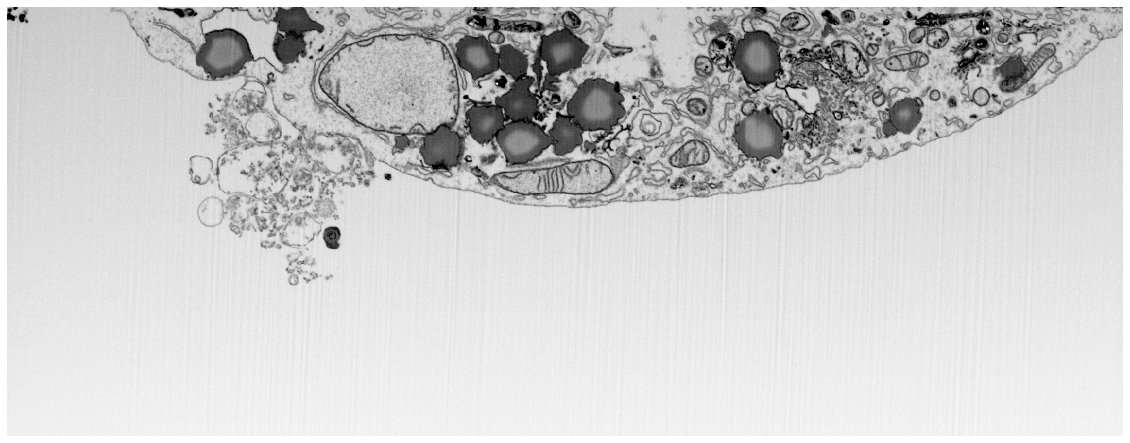

In [10]:
img = imread(rawimglist[rawfdlist[0]][500])
plt.figure(figsize = (20,20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [11]:
model = load_model(path_model)
print(model)

## Prediction Small Dataset
### Create Folder 

In [12]:
# folder name
fdnm_small = 'batch_01'
dir_checker(fdnm_small, os.path.join(pred_path, 'pred_img'))
img_path_small = os.path.join(pred_path, 'pred_img', fdnm_small)

# create folder list
for folder in rawfdlist:
    dir_checker(folder, img_path_small)

batch_01 exists in D:PerlmutterData\dl_seg_project_raw\pred_img
data_d00_batch01_loc01 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\batch_01
data_d07_batch01_loc01 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\batch_01
data_d14_batch01_loc01 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\batch_01
data_d17_batch01_loc01 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\batch_01
data_d21_batch01_loc01 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\batch_01


### Tiling Prediction with Stack Input
- Crop image into patched by a given overlap factor
- Export a cropping index
- Construct patches back into a image 

In [17]:
from core.imageprep import create_crop_idx, crop_to_patch

for idx in trange(len(rawfdlist)):
    
    folder = rawfdlist[idx]
    
    pred_input_imgs =  rawimglist_small[folder]
    pred_output_path = os.path.join(pred_path, 'pred_img', fdnm_small, folder)
    
    img = imread(rawimglist_small[folder][0])
    cropidx = create_crop_idx(img.shape, (IMG_HEIGHT, IMG_WIDTH), overlap_fac = 0.1)
    # print(cropidx)
    
    stack_predict(
                input_imgpath = pred_input_imgs, 
                output_imgpath = pred_output_path, 
                cropidx = cropidx, 
                model = model, 
                rescale = 1./255.,
                patch_size = (IMG_HEIGHT, IMG_WIDTH), 
                predict_threshold = 0.5)


Image Shape: 883, 2297
Patch size: 256, 256
Overlap Factor: 0.1
Step y: 230
Step y count: 4
Remainder in y: 167
Step x: 230
Step x count: 10
Remainder in x: 201



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297




Image Shape: 844, 2238
Patch size: 256, 256
Overlap Factor: 0.1
Step y: 230
Step y count: 4
Remainder in y: 128
Step x: 230
Step x count: 10
Remainder in x: 142



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 844, 2238



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 844, 2238



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 844, 2238



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 844, 2238



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 844, 2238



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 844, 2238



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 844, 2238



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 844, 2238



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 844, 2238



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 844, 2238




Image Shape: 938, 2216
Patch size: 256, 256
Overlap Factor: 0.1
Step y: 230
Step y count: 4
Remainder in y: 222
Step x: 230
Step x count: 10
Remainder in x: 120



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 938, 2216



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 938, 2216



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 938, 2216



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 938, 2216



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 938, 2216



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 938, 2216



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 938, 2216



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 938, 2216



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 938, 2216



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 938, 2216




Image Shape: 930, 2219
Patch size: 256, 256
Overlap Factor: 0.1
Step y: 230
Step y count: 4
Remainder in y: 214
Step x: 230
Step x count: 10
Remainder in x: 123



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 930, 2219



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 930, 2219



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 930, 2219



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 930, 2219



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 930, 2219



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 930, 2219



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 930, 2219



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 930, 2219



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 930, 2219



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 930, 2219




Image Shape: 793, 2285
Patch size: 256, 256
Overlap Factor: 0.1
Step y: 230
Step y count: 4
Remainder in y: 77
Step x: 230
Step x count: 10
Remainder in x: 189



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 793, 2285



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 793, 2285



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 793, 2285



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 793, 2285



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 793, 2285



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 793, 2285



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 793, 2285



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 793, 2285



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 793, 2285



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 793, 2285




## Prediction the Whole Dataset
### Create Folder 

In [18]:
# folder name
fdnm_whole = 'batch_02'
dir_checker(fdnm_whole, os.path.join(pred_path, 'pred_img'))
img_path_whole = os.path.join(pred_path, 'pred_img', fdnm_whole)

# create folder list
for folder in rawfdlist:
    dir_checker(folder, img_path_whole)

batch_02 exists in D:PerlmutterData\dl_seg_project_raw\pred_img
data_d00_batch01_loc01 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\batch_02
data_d07_batch01_loc01 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\batch_02
data_d14_batch01_loc01 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\batch_02
data_d17_batch01_loc01 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\batch_02
data_d21_batch01_loc01 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\batch_02


### Tiling Prediction with Stack Input
- Crop image into patched by a given overlap factor
- Export a cropping index
- Construct patches back into a image 

In [19]:
from core.imageprep import create_crop_idx, crop_to_patch

for idx in trange(len(rawfdlist)):
    
    folder = rawfdlist[idx]
    
    pred_input_imgs =  rawimglist[folder]
    pred_output_path = os.path.join(pred_path, 'pred_img', fdnm_whole, folder)
    
    img = imread(rawimglist_small[folder][0])
    cropidx = create_crop_idx(img.shape, (IMG_HEIGHT, IMG_WIDTH), overlap_fac = 0.1)
    # print(cropidx)
    
    stack_predict(
                input_imgpath = pred_input_imgs, 
                output_imgpath = pred_output_path, 
                cropidx = cropidx, 
                model = model, 
                rescale = 1./255.,
                patch_size = (IMG_HEIGHT, IMG_WIDTH), 
                predict_threshold = 0.5)


Image Shape: 883, 2297
Patch size: 256, 256
Overlap Factor: 0.1
Step y: 230
Step y count: 4
Remainder in y: 167
Step x: 230
Step x count: 10
Remainder in x: 201



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



40/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Patch Image Shape: 256, 256
Target Image Size: 883, 2297



16/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 26ms/sample


KeyboardInterrupt: 